# FITS → HD PNG preview\n\nThis notebook loads a FITS file, selects a 2D plane if needed, applies a contrast stretch, and saves an HD PNG.

Raw shape: (1, 31, 256, 256)
Using plane: 0 from stack shape: (31, 256, 256)


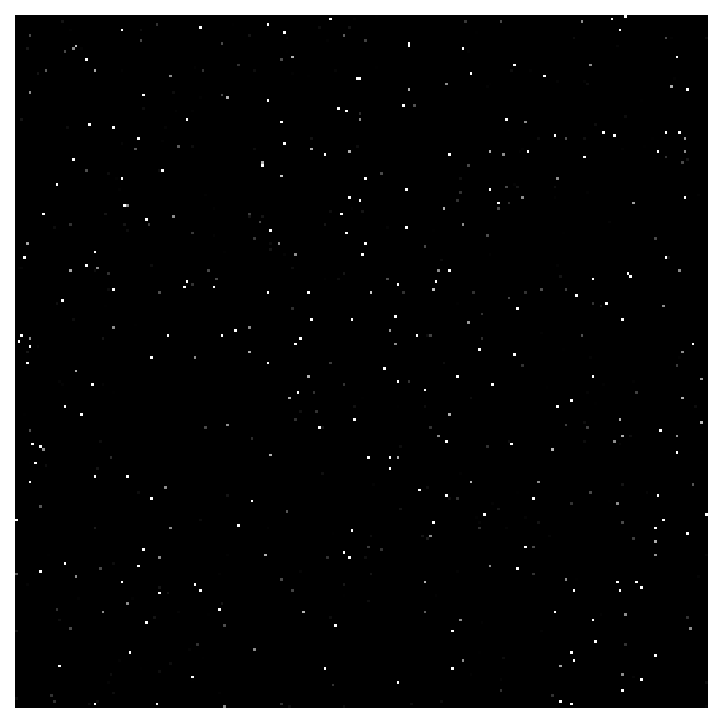

Saved: slice_hd.png


In [1]:
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

# ---- 1) Load FITS (from disk). Change this path. ----
fits_path = "ngc6503.fits"

with fits.open(fits_path, memmap=False) as hdul:
    data = hdul[0].data

if data is None:
    raise ValueError("No image data in primary HDU (hdul[0].data is None)")

print("Raw shape:", np.shape(data))

# ---- 2) Pick a single 2D plane safely ----
arr = np.asarray(data)
arr = np.squeeze(arr)  # remove length-1 dims, e.g. (1,31,256,256)->(31,256,256)

if arr.ndim < 2:
    raise ValueError(f"Data has ndim={arr.ndim}, expected at least 2D")

if arr.ndim == 2:
    img = arr
else:
    # Flatten any leading dims, keep last two as (Y,X)
    ny, nx = arr.shape[-2], arr.shape[-1]
    stack = arr.reshape(-1, ny, nx)  # e.g. (31,256,256)
    k = 0  # choose plane index (0..stack.shape[0]-1)
    img = stack[k]
    print("Using plane:", k, "from stack shape:", stack.shape)

img = img.astype(np.float64, copy=False)

# ---- 3) Sanitize NaN/Inf ----
finite = np.isfinite(img)
fill = np.median(img[finite]) if finite.any() else 0.0
img = np.where(finite, img, fill)

# ---- 4) Contrast stretch for human eyes ----
norm = ImageNormalize(
    img,
    interval=PercentileInterval(99.5),
    stretch=AsinhStretch()
)

# ---- 5) Render "HD" (high DPI / big output) ----
# Bigger figsize + higher dpi => higher-resolution PNG (does not add new data, just nicer output)
out_png = "slice_hd.png"
fig, ax = plt.subplots(figsize=(8, 8), dpi=250)   # ~2000x2000 px
ax.axis("off")
ax.imshow(img, origin="lower", cmap="gray", norm=norm, interpolation="nearest")
fig.savefig(out_png, format="png", bbox_inches="tight", pad_inches=0)
plt.close(fig)

# Show it inline too
plt.figure(figsize=(6, 6), dpi=150)
plt.axis("off")
plt.imshow(img, origin="lower", cmap="gray", norm=norm, interpolation="nearest")
plt.show()

print("Saved:", out_png)
